In [1]:
#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read in csv files as pandas dataframes
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
#convert time stamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [8]:
#extract week and year from time_stamp
engagement['week-year'] = engagement['time_stamp'].dt.strftime('%U-%Y')

In [9]:
engagement.head()

,time_stamp,user_id,visited,week-year
0,2014-04-22 03:53:30,1,1,16-2014
1,2013-11-15 03:45:04,2,1,45-2013
2,2013-11-29 03:45:04,2,1,47-2013
3,2013-12-09 03:45:04,2,1,49-2013
4,2013-12-25 03:45:04,2,1,51-2013


In [10]:
usage = engagement.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})

In [11]:
usage['adopted'] = usage['count']>=3

In [12]:
adopted_users = list(usage[usage.adopted==True].user_id.unique())

In [13]:
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

In [14]:
users_clean = users.drop(['name','email'],axis=1)
users_clean = users_clean.set_index('object_id')

In [15]:
users_clean.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [17]:
users_clean.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [18]:
#One-hot encoding of creation_source. Drop first to avoid multicollinearity
source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,source_dummies],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)#One-hot encoding of creation_source. Drop first to avoid multicollinearity
source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,source_dummies],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)

In [19]:
#Convert creation_time and last_session_creation_time to datetime
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time,unit='s')

In [20]:
#Extract months from datetime columns.
df['creation_month'] = df.creation_time.dt.month

df['last_session_creation_month'] = df.last_session_creation_time.dt.month

In [21]:
#convert invited by user_id to boolean
df['invited'] = df.invited_by_user_id.notnull().astype(int)

In [22]:
#drop redundant columns that have been converted to features
df = df.drop(['creation_time','last_session_creation_time','invited_by_user_id'],axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
opted_in_to_mailing_list       12000 non-null int64
enabled_for_marketing_drip     12000 non-null int64
org_id                         12000 non-null int64
adopted                        12000 non-null int32
ORG_INVITE                     12000 non-null uint8
PERSONAL_PROJECTS              12000 non-null uint8
SIGNUP                         12000 non-null uint8
SIGNUP_GOOGLE_AUTH             12000 non-null uint8
creation_month                 12000 non-null int64
last_session_creation_month    8823 non-null float64
invited                        12000 non-null int32
dtypes: float64(1), int32(2), int64(4), uint8(4)
memory usage: 703.1 KB


In [24]:
df['last_session_creation_month'] = df['last_session_creation_month'].fillna(0).astype(int)

11.9 % of observed users were adopted


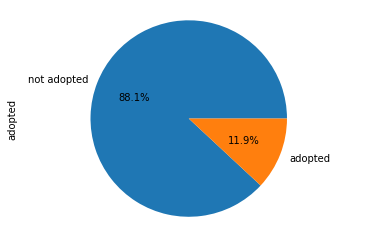

In [25]:
print(format(df.adopted.sum()/df.adopted.count()*100,'1.1f'), '% of observed users were adopted')
_ = df.adopted.value_counts().plot(kind='pie',labels=['not adopted','adopted'],autopct='%1.1f%%')
_ = plt.axis('equal')

In [26]:
#Split data into X and y
X = df.drop(['adopted'],axis=1)
y = df['adopted']

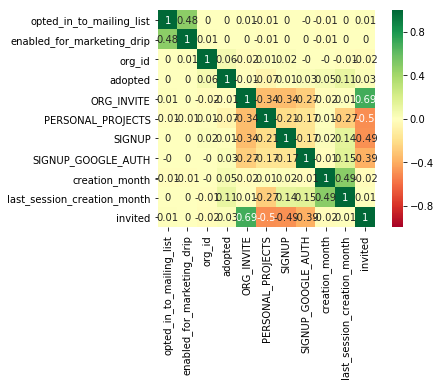

In [27]:
#Correlation matrix
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

The correlation matrix shows that last_session creation_month has the strongest direct, linear correation with adopted (0.22). None of the other columns have a correlation factor greater than 0.7 so no multicollinearity is evident from this matrix. We will not look at the variance inflation factors to confirm.

In [28]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = X
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
9,5.706871,invited
5,1.995989,SIGNUP
4,1.934526,PERSONAL_PROJECTS
3,1.915684,ORG_INVITE
6,1.655964,SIGNUP_GOOGLE_AUTH


# MODEL

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [35]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

Using TensorFlow backend.


[(0, 7398), (1, 7398)]


In [36]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
rf.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_rf = rf.predict(X_test)

In [37]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.95845
Test Accuracy: 0.94278
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3045          125
Actual 1           81          349
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3170
           1       0.74      0.81      0.77       430

   micro avg       0.94      0.94      0.94      3600
   macro avg       0.86      0.89      0.87      3600
weighted avg       0.95      0.94      0.94      3600



In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# instantiate model to run 50 estimators
gb = GradientBoostingClassifier(random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_gb = cross_val_score(gb, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
gb.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_gb = gb.predict(X_test)

In [39]:
print("Train Accuracy:",format(np.mean(cv_accuracy_gb),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_gb),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_gb),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_gb))

Train Accuracy: 0.94086
Test Accuracy: 0.93556
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3002          168
Actual 1           64          366
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3170
           1       0.69      0.85      0.76       430

   micro avg       0.94      0.94      0.94      3600
   macro avg       0.83      0.90      0.86      3600
weighted avg       0.94      0.94      0.94      3600



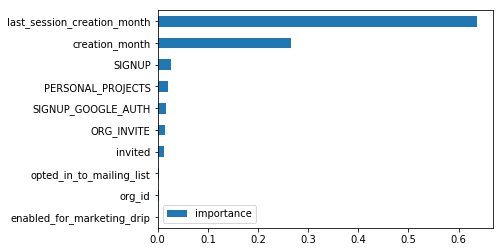

In [40]:
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances.plot(kind='barh')

Based on the feature importance plot, we can see that the last_session_creation_month is the most important feature, followed by the creation_month. We can perform some EDA in order to better understand how the last_session_creation_month is correlated to adoption.

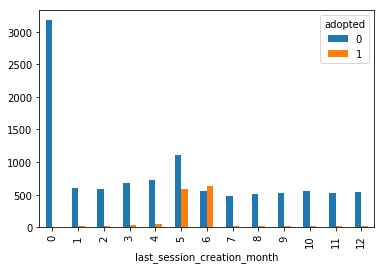

In [41]:
pd.crosstab(df.last_session_creation_month,df.adopted).plot(kind='bar')

We can see that, obviously, users who have not logged in within the past 2 years will not be considered adopted users and there are a significant number of users who have not logged in within the last 2 years. We would want to perform further analysis on this subset of users to better understand why they have not logged in. Most adopted users last logged in in May and June so I would want to understand what was done in May and June (any special deals etc.) that could have led to better user retention.